In [1]:
import tensorflow as tf
from tensorflow.keras import Model, layers
import numpy as np
import math
from sympy import *
import tensorflow as tf
import tensorflow as tf
from sklearn import model_selection
import numpy as np
import argparse
from random import Random, random
import os
import pickle
import matplotlib.pyplot as plt

Code adapted from: https://github.com/ranaa-b/OOCS/tree/main

@InProceedings{pmlr-v139-babaiee21a,
  title = 	 {On-Off Center-Surround Receptive Fields for Accurate and Robust Image Classification},
  author =       {Babaiee, Zahra and Hasani, Ramin and Lechner, Mathias and Rus, Daniela and Grosu, Radu},
  booktitle = 	 {Proceedings of the 38th International Conference on Machine Learning},
  pages = 	 {478--489},
  year = 	 {2021},
  editor = 	 {Meila, Marina and Zhang, Tong},
  volume = 	 {139},
  series = 	 {Proceedings of Machine Learning Research},
  month = 	 {18--24 Jul},
  publisher =    {PMLR},
  pdf = 	 {http://proceedings.mlr.press/v139/babaiee21a/babaiee21a.pdf},
  url = 	 {http://proceedings.mlr.press/v139/babaiee21a.html},
}      

In [2]:
def DoG_OOCS(x, y, center, gamma, radius):
    """compute weight at location (x, y) in the OOCS kernel with given parameters
        Parameters:
            x , y : position of the current weight
            center : position of the kernel center
            gamma : center to surround ratio
            radius : center radius

        Returns:
            excite and inhibit : calculated from Equation2 in the paper, without the coefficients A-c and A-s

    """
    # compute sigma from radius of the center and gamma(center to surround ratio)
    sigma = (radius / (2 * gamma)) * (math.sqrt((1 - gamma ** 2) / (-math.log(gamma))))
    excite = (1 / (gamma ** 2)) * math.exp(-1 * ((x - center) ** 2 + (y - center) ** 2) / (2 * ((gamma * sigma) ** 2)))
    inhibit = math.exp(-1 * ((x - center) ** 2 + (y - center) ** 2) / (2 * (sigma ** 2)))

    return excite , inhibit


def On_Off_Center_filters(radius, gamma, in_channels, out_channels, off=False):
    """compute the kernel filters with given shape and parameters
        Parameters:
            gamma : center to surround ratio
            radius : center radius
            in_channels and out_channels: filter dimensions
            off(boolean) : if false, calculates on center kernel, and if true, off center

        Returns:
            kernel : On or Off center conv filters with requested shape

    """

    # size of the kernel
    kernel_size = int((radius/gamma)*2-1)
    # center node index
    centerX = int((kernel_size+1)/2)

    posExcite = 0
    posInhibit = 0
    negExcite = 0
    negInhibit = 0

    for i in range(kernel_size):
        for j in range(kernel_size):
            excite, inhibit = DoG_OOCS(i+1,j+1, centerX, gamma, radius)
            if excite > inhibit:
                posExcite += excite
                posInhibit += inhibit
            else:
                negExcite += excite
                negInhibit += inhibit

    # Calculating A-c and A-s, with requiring the positive vlaues sum up to 1 and negative vlaues to -1
    x, y = symbols('x y')
    solution = solve((x * posExcite + y * posInhibit - 1, negExcite * x + negInhibit * y + 1), x, y)
    A_c, A_s = float(solution[x].evalf()), float(solution[y].evalf())

    # making the On-center and Off-center conv filters
    kernel = np.zeros([kernel_size, kernel_size, in_channels, out_channels])

    for i in range(kernel_size):
        for j in range(kernel_size):
            excite, inhibit = DoG_OOCS(i+1,j+1, centerX, gamma, radius)
            weight = excite*A_c + inhibit*A_s
            if off:
                weight *= -1.
            kernel[i][j] = tf.fill([in_channels, out_channels], weight)

    return kernel.astype(np.float32)

In [4]:
class OOCS(Model):

    def __init__(self):
        super(OOCS, self).__init__()
        self.conv_On_filters = On_Off_Center_filters(radius=1.0, gamma=1. / 2., in_channels=1, out_channels=1, off=False)
        self.conv_Off_filters = On_Off_Center_filters(radius=1.0, gamma=1. / 2., in_channels=1, out_channels=1, off=True)

        self.conv11 = layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation=tf.nn.relu)
        self.conv12 = layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation=tf.nn.relu)
        self.maxpool1 = layers.MaxPool2D(2, strides=2)
        self.conv21 = layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation=tf.nn.relu)
        self.conv22 = layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation=tf.nn.relu)
        self.maxpool2 = layers.MaxPool2D(2, strides=2)
        self.flatten = layers.Flatten()
        # Fully connected layer.
        self.fc1 = layers.Dense(100, activation=tf.nn.relu)

        # Output layer, class prediction.
        self.out = layers.Dense(num_classes)

    # Set forward pass
    def call(self, x, is_training=False):
        x = tf.reshape(x, [-1, 28, 28, 1])

        sm_on = self.on_center_modulation_small(x, kernel_size=3, in_channels=1, out_channels=1)
        sm_off = self.off_center_modulation_small(x, kernel_size=3, in_channels=1, out_channels=1)
        x = sm_on + sm_off

        x = self.conv11(x)
        x = self.conv12(x)
        x = self.maxpool1(x)
        x = self.conv21(x)
        x = self.conv22(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)

        if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
        return x

    def on_center_modulation_small(self, inputs, kernel_size, in_channels, out_channels):
        filter_weights = tf.Variable(tf.cast(tf.reshape(self.conv_On_filters, (kernel_size, kernel_size, in_channels, out_channels)),dtype=tf.float32), trainable=False, dtype=tf.float32)
        output = tf.nn.conv2d(inputs, filters=filter_weights, strides=1, padding='VALID')
        output = tf.pad(output, tf.constant([[0, 0], [1, 1], [1, 1],[0, 0]]), "SYMMETRIC")
        return tf.nn.relu(output)

    def off_center_modulation_small(self, inputs, kernel_size, in_channels, out_channels):
        filter_weights = tf.Variable(tf.cast(tf.reshape(self.conv_Off_filters, (kernel_size, kernel_size, in_channels, out_channels)),dtype=tf.float32), trainable=False, dtype=tf.float32)
        output = tf.nn.conv2d(inputs, filters=filter_weights, strides=1, padding='VALID')
        output = tf.pad(output, tf.constant([[0, 0], [1, 1], [1, 1],[0, 0]]), "SYMMETRIC")
        return tf.nn.relu(output)

In [5]:
class OOCS2(Model):

    def __init__(self):
        super(OOCS2, self).__init__()
        self.conv_On_filters = On_Off_Center_filters(radius=1.0, gamma=1. / 2., in_channels=1, out_channels=1, off=False)
        self.conv_Off_filters = On_Off_Center_filters(radius=1.0, gamma=1. / 2., in_channels=1, out_channels=1, off=True)

        self.conv1 = layers.Conv2D(12, kernel_size=5, activation='relu')
        self.conv2 = layers.Conv2D(20, kernel_size=5, activation='relu')
        self.fc1 = layers.Dense(160, activation='relu')
        self.fc2 = layers.Dense(50, activation='relu')
        self.fc3 = layers.Dense(10)
        self.drop = layers.Dropout(rate=0.5)

    # Set forward pass
    def call(self, x, is_training=False):
        x = tf.reshape(x, [-1, 28, 28, 1])

        sm_on = self.on_center_modulation_small(x, kernel_size=3, in_channels=1, out_channels=1)
        sm_off = self.off_center_modulation_small(x, kernel_size=3, in_channels=1, out_channels=1)
        x = sm_on + sm_off

        x = tf.nn.relu(tf.nn.max_pool2d(self.conv1(x), ksize=2, strides=2, padding='VALID'))
        x = tf.nn.relu(tf.nn.max_pool2d(self.conv2(x), ksize=2, strides=2, padding='VALID'))
        x = tf.reshape(x, (-1, 320))
        x = tf.nn.gelu(self.drop(self.fc1(x)))
        x = tf.nn.gelu(self.drop(self.fc2(x)))
        x = self.fc3(x)

        if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
        return x

    def on_center_modulation_small(self, inputs, kernel_size, in_channels, out_channels):
        filter_weights = tf.Variable(tf.cast(tf.reshape(self.conv_On_filters, (kernel_size, kernel_size, in_channels, out_channels)),dtype=tf.float32), trainable=False, dtype=tf.float32)
        output = tf.nn.conv2d(inputs, filters=filter_weights, strides=1, padding='VALID')
        output = tf.pad(output, tf.constant([[0, 0], [1, 1], [1, 1],[0, 0]]), "SYMMETRIC")
        return tf.nn.relu(output)

    def off_center_modulation_small(self, inputs, kernel_size, in_channels, out_channels):
        filter_weights = tf.Variable(tf.cast(tf.reshape(self.conv_Off_filters, (kernel_size, kernel_size, in_channels, out_channels)),dtype=tf.float32), trainable=False, dtype=tf.float32)
        output = tf.nn.conv2d(inputs, filters=filter_weights, strides=1, padding='VALID')
        output = tf.pad(output, tf.constant([[0, 0], [1, 1], [1, 1],[0, 0]]), "SYMMETRIC")
        return tf.nn.relu(output)

In [6]:
class Net(Model):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = layers.Conv2D(12, kernel_size=5, activation='relu')
        self.conv2 = layers.Conv2D(20, kernel_size=5, activation='relu')
        self.fc1 = layers.Dense(160, activation='relu')
        self.fc2 = layers.Dense(50, activation='relu')
        self.fc3 = layers.Dense(10)
        self.drop = layers.Dropout(rate=0.5)

    def call(self, x, is_training=False):
        x = tf.reshape(x, [-1, 28, 28, 1])
        x = tf.nn.relu(tf.nn.max_pool2d(self.conv1(x), ksize=2, strides=2, padding='VALID'))
        x = tf.nn.relu(tf.nn.max_pool2d(self.conv2(x), ksize=2, strides=2, padding='VALID'))
        x = tf.reshape(x, (-1, 320))
        x = tf.nn.gelu(self.drop(self.fc1(x)))
        x = tf.nn.gelu(self.drop(self.fc2(x)))
        x = self.fc3(x)
        if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
        return x

In [7]:
def add_condiment(img,amount):
    idx = np.random.choice(range(784), size=int(784*amount),replace=False)
    new_img = img.reshape(784).copy()
    new_img[idx[:int(784*amount/2)]] = 1
    new_img[idx[int(784*amount/2):]] = 0
    return new_img.reshape(28,28)




def cross_entropy_loss(x, y):
    # Convert labels to int 64 for tf cross-entropy function.
    y = tf.cast(y, tf.int64)
    y = tf.reshape(y, [-1])
    # Apply softmax to logits and compute cross-entropy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    # Average loss across the batch.
    return tf.reduce_mean(loss)


# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    y = tf.cast(y_true, tf.int64)
    y = tf.reshape(y, [-1])

    correct_prediction = tf.equal(tf.argmax(y_pred, 1), y)
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        # Forward pass.
        pred = conv_net(x, is_training=True)
        # Compute loss.
        loss = cross_entropy_loss(pred, y)

    # Variables to update, i.e. trainable variables.
    trainable_variables = conv_net.trainable_variables

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)

    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))


In [8]:
OOCS_run_results = []
for run in range(5):

    # Training parameters.
    learning_rate = 0.01
    epochs = 7
    batch_size = 64
    lr_drop = 5
    lr_decay = 1e-6
    num_classes = 10

    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    # Normalize images value from [0, 255] to [0, 1].
    x_train, x_test = x_train / 255., x_test / 255.
    x_train, x_val, y_train, y_val = model_selection.train_test_split(x_train, y_train, test_size=0.2, random_state=42)
    val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_data = val_data.shuffle(5000).batch(batch_size).prefetch(1)

    train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_data = train_data.shuffle(5000).batch(batch_size).prefetch(1)

    # Build neural network model.

    conv_net = OOCS()

    # Cross-Entropy Loss.
    # Note that this will apply 'softmax' to the logits.


    # Stochastic gradient descent optimizer.
    optimizer = tf.optimizers.SGD(learning_rate=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)

    # Optimization process.

    losses = []
    accs = []
    losses = []
    accs = []
    val_losses = []
    val_accs = []

    # Run training for the given number of steps.
    for epoch in range(epochs):
        sum_acc, sum_loss, sum_val_acc, sum_val_loss = 0., 0., 0., 0.
        optimizer.learning_rate = learning_rate * (0.5 ** (epoch // lr_drop))

        for step, (batch_x, batch_y) in enumerate(train_data.take(-1), 1):
            # Run the optimization to update W and b values.
            run_optimization(batch_x, batch_y)

            pred = conv_net(batch_x)
            sum_loss += cross_entropy_loss(pred, batch_y)
            sum_acc += accuracy(pred, batch_y)

            val_batch_x, val_batch_y = list(val_data.take(1))[0]
            val_pred = conv_net(val_batch_x)
            sum_val_loss += cross_entropy_loss(val_pred, val_batch_y)
            sum_val_acc += accuracy(val_pred, val_batch_y)

        acc, loss, val_acc, val_loss = sum_acc / step, sum_loss / step, sum_val_acc / step, sum_val_loss / step
        print("epoch: %i, step:%i, loss: %f, accuracy: %f" % (epoch, step, loss, acc))

        print("validation epoch: %i, loss: %f, accuracy: %f" % (epoch, val_loss, val_acc))
        losses.append(loss)
        accs.append(acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        

    results = {}
    pred = conv_net(x_test)
    loss = cross_entropy_loss(pred, y_test)
    acc = accuracy(pred, y_test)
    results['original acc'] = acc
    results['original loss'] = loss
    print("test on original data, loss: %f, accuracy: %f" % (loss, acc))


    x_test_dark = []
    for x in x_test:
        x_test_dark.append(abs(x - 255.0))

    x_test_dark = np.array(x_test_dark)
    
    pred = conv_net(x_test_dark)
    loss = cross_entropy_loss(pred, y_test)
    acc = accuracy(pred, y_test)
    results['inverted acc'] = acc
    results['inverted loss'] = loss
    print("test on inverted data, loss: %f, accuracy: %f" % (loss, acc))

    
    
    noise_acc,noise_loss = [],[]
    for amount in np.linspace(0,1,20):
        x_test_noise = []
        for x in x_test:
            x_test_noise.append(add_condiment(x, amount))
        x_test_noise = np.array(x_test_noise)

        pred = conv_net(x_test_noise)
        loss = cross_entropy_loss(pred, y_test)
        acc = accuracy(pred, y_test)
        noise_acc.append(acc)
        noise_loss.append(loss)
        print("test on noisy data, loss: %f, accuracy: %f" % (loss, acc))
    results[f'noise acc'] = noise_acc
    results[f'noise loss'] = noise_loss 
    
    
    
    gauss_acc,gauss_loss = [],[]
    for amount in np.linspace(0,1,20):
        x_test_gauss = []
        for x in x_test:
            x_test_gauss.append(np.abs(x + np.random.normal(0, amount, (28,28))))
        x_test_gauss = np.array(x_test_gauss)

        pred = conv_net(x_test_gauss)
        loss = cross_entropy_loss(pred, y_test)
        acc = accuracy(pred, y_test)
        gauss_acc.append(acc)
        gauss_loss.append(loss)
        print("test on gauss data, loss: %f, accuracy: %f" % (loss, acc)) 
    results[f'gauss acc'] = gauss_acc
    results[f'gauss loss'] = gauss_loss
    
    
    
    sin_acc,sin_loss = [],[]    
    for amount in np.linspace(0,10,20):
        sin_arr = np.empty([28,28])
        sinn = np.sin(np.linspace(0,np.pi,28)) * amount
        for i in range(28):
            for j in range(28):
                sin_arr[i][j] = sinn[int(np.sqrt((14-i)**2+(14-j)**2))]

        x_test_sin = []
        for x in x_test:
            x_test_sin.append(x + 1- sin_arr)
        x_test_sin = np.array(x_test_sin)

        pred = conv_net(x_test_sin)
        loss = cross_entropy_loss(pred, y_test)
        acc = accuracy(pred, y_test)
        sin_acc.append(acc)
        sin_loss.append(loss)
        print("test on sin data, loss: %f, accuracy: %f" % (loss, acc)) 
    results[f'sin acc'] = sin_acc
    results[f'sin loss'] = sin_loss        
    
    
    con_acc,con_loss = [],[]  
    for amount in np.linspace(0,1,20):
        x_test_con = []
        for x in x_test:
            x_test_con.append(x + (1-x)*amount)
        x_test_con = np.array(x_test_con)

        pred = conv_net(x_test_con)
        loss = cross_entropy_loss(pred, y_test)
        acc = accuracy(pred, y_test)
        con_acc.append(acc)
        con_loss.append(loss)
        print("test on con data, loss: %f, accuracy: %f" % (loss, acc)) 
    results[f'con acc'] = con_acc
    results[f'con loss'] = con_loss   
        
    OOCS_run_results.append(results)

C:\Users\alked\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


epoch: 0, step:750, loss: 3.985670, accuracy: 0.700646
validation epoch: 0, loss: 3.997749, accuracy: 0.686125
epoch: 1, step:750, loss: 3.862127, accuracy: 0.784375
validation epoch: 1, loss: 3.866479, accuracy: 0.779646
epoch: 2, step:750, loss: 3.850053, accuracy: 0.789563
validation epoch: 2, loss: 3.859106, accuracy: 0.779354
epoch: 3, step:750, loss: 3.843631, accuracy: 0.792354
validation epoch: 3, loss: 3.851684, accuracy: 0.782604
epoch: 4, step:750, loss: 3.839381, accuracy: 0.794208
validation epoch: 4, loss: 3.847355, accuracy: 0.785771
epoch: 5, step:750, loss: 3.835544, accuracy: 0.794292
validation epoch: 5, loss: 3.843804, accuracy: 0.786604
epoch: 6, step:750, loss: 3.833302, accuracy: 0.795604
validation epoch: 6, loss: 3.842785, accuracy: 0.786313
test on original data, loss: 3.841539, accuracy: 0.787400
test on inverted data, loss: 3.841541, accuracy: 0.787400
test on noisy data, loss: 3.841539, accuracy: 0.787400
test on noisy data, loss: 4.262788, accuracy: 0.4497

test on gauss data, loss: 4.511290, accuracy: 0.109200
test on gauss data, loss: 4.509799, accuracy: 0.110600
test on sin data, loss: 3.651409, accuracy: 0.978000
test on sin data, loss: 3.654077, accuracy: 0.976600
test on sin data, loss: 3.661177, accuracy: 0.971800
test on sin data, loss: 3.675415, accuracy: 0.961400
test on sin data, loss: 3.700974, accuracy: 0.938100
test on sin data, loss: 3.741646, accuracy: 0.901400
test on sin data, loss: 3.800987, accuracy: 0.843500
test on sin data, loss: 3.875507, accuracy: 0.767500
test on sin data, loss: 3.958730, accuracy: 0.680100
test on sin data, loss: 4.043559, accuracy: 0.588700
test on sin data, loss: 4.123362, accuracy: 0.504400
test on sin data, loss: 4.195198, accuracy: 0.425800
test on sin data, loss: 4.257188, accuracy: 0.357000
test on sin data, loss: 4.309329, accuracy: 0.302700
test on sin data, loss: 4.352154, accuracy: 0.260100
test on sin data, loss: 4.387128, accuracy: 0.226100
test on sin data, loss: 4.415531, accuracy

test on original data, loss: 3.647769, accuracy: 0.980400
test on inverted data, loss: 3.647769, accuracy: 0.980400
test on noisy data, loss: 3.647769, accuracy: 0.980400
test on noisy data, loss: 4.020187, accuracy: 0.610700
test on noisy data, loss: 4.206493, accuracy: 0.425800
test on noisy data, loss: 4.327679, accuracy: 0.297100
test on noisy data, loss: 4.400041, accuracy: 0.222600
test on noisy data, loss: 4.449972, accuracy: 0.170900
test on noisy data, loss: 4.478994, accuracy: 0.141900
test on noisy data, loss: 4.495225, accuracy: 0.125700
test on noisy data, loss: 4.501752, accuracy: 0.120000
test on noisy data, loss: 4.508594, accuracy: 0.111200
test on noisy data, loss: 4.510275, accuracy: 0.110700
test on noisy data, loss: 4.512317, accuracy: 0.109400
test on noisy data, loss: 4.515583, accuracy: 0.106100
test on noisy data, loss: 4.515700, accuracy: 0.106200
test on noisy data, loss: 4.522348, accuracy: 0.096900
test on noisy data, loss: 4.519158, accuracy: 0.101900
test

test on sin data, loss: 4.184457, accuracy: 0.438600
test on sin data, loss: 4.238472, accuracy: 0.382400
test on sin data, loss: 4.285513, accuracy: 0.334300
test on sin data, loss: 4.326130, accuracy: 0.291300
test on sin data, loss: 4.360688, accuracy: 0.254800
test on sin data, loss: 4.389842, accuracy: 0.225900
test on sin data, loss: 4.414148, accuracy: 0.203300
test on con data, loss: 3.649831, accuracy: 0.978100
test on con data, loss: 3.649876, accuracy: 0.978500
test on con data, loss: 3.650354, accuracy: 0.978500
test on con data, loss: 3.651412, accuracy: 0.978400
test on con data, loss: 3.653297, accuracy: 0.977500
test on con data, loss: 3.656393, accuracy: 0.975400
test on con data, loss: 3.661348, accuracy: 0.972400
test on con data, loss: 3.669427, accuracy: 0.969600
test on con data, loss: 3.683069, accuracy: 0.963000
test on con data, loss: 3.706629, accuracy: 0.948300
test on con data, loss: 3.747934, accuracy: 0.918600
test on con data, loss: 3.818574, accuracy: 0.

In [9]:
OOCS2_run_results = []
for run in range(5):

    # Training parameters.
    learning_rate = 0.01
    epochs = 7
    batch_size = 64
    lr_drop = 5
    lr_decay = 1e-6
    num_classes = 10

    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    # Normalize images value from [0, 255] to [0, 1].
    x_train, x_test = x_train / 255., x_test / 255.
    x_train, x_val, y_train, y_val = model_selection.train_test_split(x_train, y_train, test_size=0.2, random_state=42)
    val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_data = val_data.shuffle(5000).batch(batch_size).prefetch(1)

    train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_data = train_data.shuffle(5000).batch(batch_size).prefetch(1)

    # Build neural network model.

    conv_net = OOCS2()

    # Cross-Entropy Loss.
    # Note that this will apply 'softmax' to the logits.


    # Stochastic gradient descent optimizer.
    optimizer = tf.optimizers.SGD(learning_rate=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)

    # Optimization process.

    losses = []
    accs = []
    losses = []
    accs = []
    val_losses = []
    val_accs = []

    # Run training for the given number of steps.
    for epoch in range(epochs):
        sum_acc, sum_loss, sum_val_acc, sum_val_loss = 0., 0., 0., 0.
        optimizer.learning_rate = learning_rate * (0.5 ** (epoch // lr_drop))

        for step, (batch_x, batch_y) in enumerate(train_data.take(-1), 1):
            # Run the optimization to update W and b values.
            run_optimization(batch_x, batch_y)

            pred = conv_net(batch_x)
            sum_loss += cross_entropy_loss(pred, batch_y)
            sum_acc += accuracy(pred, batch_y)

            val_batch_x, val_batch_y = list(val_data.take(1))[0]
            val_pred = conv_net(val_batch_x)
            sum_val_loss += cross_entropy_loss(val_pred, val_batch_y)
            sum_val_acc += accuracy(val_pred, val_batch_y)

        acc, loss, val_acc, val_loss = sum_acc / step, sum_loss / step, sum_val_acc / step, sum_val_loss / step
        print("epoch: %i, step:%i, loss: %f, accuracy: %f" % (epoch, step, loss, acc))

        print("validation epoch: %i, loss: %f, accuracy: %f" % (epoch, val_loss, val_acc))
        losses.append(loss)
        accs.append(acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        


    
    

    results = {}
    pred = conv_net(x_test)
    loss = cross_entropy_loss(pred, y_test)
    acc = accuracy(pred, y_test)
    results['original acc'] = acc
    results['original loss'] = loss
    print("test on original data, loss: %f, accuracy: %f" % (loss, acc))


    x_test_dark = []
    for x in x_test:
        x_test_dark.append(abs(x - 255.0))

    x_test_dark = np.array(x_test_dark)
    
    pred = conv_net(x_test_dark)
    loss = cross_entropy_loss(pred, y_test)
    acc = accuracy(pred, y_test)
    results['inverted acc'] = acc
    results['inverted loss'] = loss
    print("test on inverted data, loss: %f, accuracy: %f" % (loss, acc))

    
    
    noise_acc,noise_loss = [],[]
    for amount in np.linspace(0,1,20):
        x_test_noise = []
        for x in x_test:
            x_test_noise.append(add_condiment(x, amount))
        x_test_noise = np.array(x_test_noise)

        pred = conv_net(x_test_noise)
        loss = cross_entropy_loss(pred, y_test)
        acc = accuracy(pred, y_test)
        noise_acc.append(acc)
        noise_loss.append(loss)
        print("test on noisy data, loss: %f, accuracy: %f" % (loss, acc))
    results[f'noise acc'] = noise_acc
    results[f'noise loss'] = noise_loss 
    
    
    
    gauss_acc,gauss_loss = [],[]
    for amount in np.linspace(0,1,20):
        x_test_gauss = []
        for x in x_test:
            x_test_gauss.append(np.abs(x + np.random.normal(0, amount, (28,28))))
        x_test_gauss = np.array(x_test_gauss)

        pred = conv_net(x_test_gauss)
        loss = cross_entropy_loss(pred, y_test)
        acc = accuracy(pred, y_test)
        gauss_acc.append(acc)
        gauss_loss.append(loss)
        print("test on gauss data, loss: %f, accuracy: %f" % (loss, acc)) 
    results[f'gauss acc'] = gauss_acc
    results[f'gauss loss'] = gauss_loss
    
    
    
    sin_acc,sin_loss = [],[]    
    for amount in np.linspace(0,10,20):
        sin_arr = np.empty([28,28])
        sinn = np.sin(np.linspace(0,np.pi,28)) * amount
        for i in range(28):
            for j in range(28):
                sin_arr[i][j] = sinn[int(np.sqrt((14-i)**2+(14-j)**2))]

        x_test_sin = []
        for x in x_test:
            x_test_sin.append(x + 1- sin_arr)
        x_test_sin = np.array(x_test_sin)

        pred = conv_net(x_test_sin)
        loss = cross_entropy_loss(pred, y_test)
        acc = accuracy(pred, y_test)
        sin_acc.append(acc)
        sin_loss.append(loss)
        print("test on sin data, loss: %f, accuracy: %f" % (loss, acc)) 
    results[f'sin acc'] = sin_acc
    results[f'sin loss'] = sin_loss        
    
    
    con_acc,con_loss = [],[]  
    for amount in np.linspace(0,1,20):
        x_test_con = []
        for x in x_test:
            x_test_con.append(x + (1-x)*amount)
        x_test_con = np.array(x_test_con)

        pred = conv_net(x_test_con)
        loss = cross_entropy_loss(pred, y_test)
        acc = accuracy(pred, y_test)
        con_acc.append(acc)
        con_loss.append(loss)
        print("test on con data, loss: %f, accuracy: %f" % (loss, acc)) 
    results[f'con acc'] = con_acc
    results[f'con loss'] = con_loss        
    OOCS2_run_results.append(results)

epoch: 0, step:750, loss: 1.749836, accuracy: 0.760146
validation epoch: 0, loss: 1.764610, accuracy: 0.740708
epoch: 1, step:750, loss: 1.522181, accuracy: 0.966021
validation epoch: 1, loss: 1.531684, accuracy: 0.951771
epoch: 2, step:750, loss: 1.504058, accuracy: 0.976875
validation epoch: 2, loss: 1.513182, accuracy: 0.963250
epoch: 3, step:750, loss: 1.495178, accuracy: 0.981396
validation epoch: 3, loss: 1.504983, accuracy: 0.968167
epoch: 4, step:750, loss: 1.487778, accuracy: 0.986375
validation epoch: 4, loss: 1.499276, accuracy: 0.971292
epoch: 5, step:750, loss: 1.482689, accuracy: 0.988146
validation epoch: 5, loss: 1.491947, accuracy: 0.976625
epoch: 6, step:750, loss: 1.479820, accuracy: 0.990125
validation epoch: 6, loss: 1.489900, accuracy: 0.977833
test on original data, loss: 1.492901, accuracy: 0.975600
test on inverted data, loss: 1.492900, accuracy: 0.975600
test on noisy data, loss: 1.492901, accuracy: 0.975600
test on noisy data, loss: 1.784901, accuracy: 0.6871

test on gauss data, loss: 2.357621, accuracy: 0.100400
test on gauss data, loss: 2.359286, accuracy: 0.098700
test on sin data, loss: 1.487341, accuracy: 0.979300
test on sin data, loss: 1.488217, accuracy: 0.978800
test on sin data, loss: 1.490507, accuracy: 0.978000
test on sin data, loss: 1.495309, accuracy: 0.974300
test on sin data, loss: 1.505828, accuracy: 0.968000
test on sin data, loss: 1.528094, accuracy: 0.950300
test on sin data, loss: 1.566749, accuracy: 0.916800
test on sin data, loss: 1.619282, accuracy: 0.860800
test on sin data, loss: 1.680646, accuracy: 0.793400
test on sin data, loss: 1.747137, accuracy: 0.724500
test on sin data, loss: 1.815984, accuracy: 0.655000
test on sin data, loss: 1.886992, accuracy: 0.580900
test on sin data, loss: 1.958952, accuracy: 0.501700
test on sin data, loss: 2.027004, accuracy: 0.424100
test on sin data, loss: 2.087328, accuracy: 0.361600
test on sin data, loss: 2.139141, accuracy: 0.305600
test on sin data, loss: 2.182828, accuracy

test on original data, loss: 1.491175, accuracy: 0.976400
test on inverted data, loss: 1.491176, accuracy: 0.976400
test on noisy data, loss: 1.491175, accuracy: 0.976400
test on noisy data, loss: 1.818513, accuracy: 0.647600
test on noisy data, loss: 2.069173, accuracy: 0.386400
test on noisy data, loss: 2.187228, accuracy: 0.262800
test on noisy data, loss: 2.257847, accuracy: 0.188100
test on noisy data, loss: 2.293331, accuracy: 0.153400
test on noisy data, loss: 2.320429, accuracy: 0.126600
test on noisy data, loss: 2.331029, accuracy: 0.118000
test on noisy data, loss: 2.340309, accuracy: 0.109300
test on noisy data, loss: 2.345628, accuracy: 0.107200
test on noisy data, loss: 2.351869, accuracy: 0.100700
test on noisy data, loss: 2.354279, accuracy: 0.099600
test on noisy data, loss: 2.355805, accuracy: 0.099600
test on noisy data, loss: 2.357919, accuracy: 0.098500
test on noisy data, loss: 2.359992, accuracy: 0.097600
test on noisy data, loss: 2.360676, accuracy: 0.097500
test

test on sin data, loss: 2.028323, accuracy: 0.425900
test on sin data, loss: 2.077746, accuracy: 0.371400
test on sin data, loss: 2.119245, accuracy: 0.330600
test on sin data, loss: 2.154275, accuracy: 0.297000
test on sin data, loss: 2.184476, accuracy: 0.266600
test on sin data, loss: 2.211189, accuracy: 0.238500
test on sin data, loss: 2.234735, accuracy: 0.214300
test on con data, loss: 1.489855, accuracy: 0.977200
test on con data, loss: 1.490877, accuracy: 0.976900
test on con data, loss: 1.492908, accuracy: 0.974900
test on con data, loss: 1.496295, accuracy: 0.973200
test on con data, loss: 1.501776, accuracy: 0.970300
test on con data, loss: 1.510493, accuracy: 0.967500
test on con data, loss: 1.524250, accuracy: 0.960500
test on con data, loss: 1.545770, accuracy: 0.946400
test on con data, loss: 1.578228, accuracy: 0.927500
test on con data, loss: 1.624803, accuracy: 0.891800
test on con data, loss: 1.686316, accuracy: 0.834700
test on con data, loss: 1.764640, accuracy: 0.

In [10]:
Net_run_results = []
for run in range(5):

    # Training parameters.
    learning_rate = 0.01
    epochs = 7
    batch_size = 64
    lr_drop = 5
    lr_decay = 1e-6
    num_classes = 10

    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    # Normalize images value from [0, 255] to [0, 1].
    x_train, x_test = x_train / 255., x_test / 255.
    x_train, x_val, y_train, y_val = model_selection.train_test_split(x_train, y_train, test_size=0.2, random_state=42)
    val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_data = val_data.shuffle(5000).batch(batch_size).prefetch(1)

    train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_data = train_data.shuffle(5000).batch(batch_size).prefetch(1)

    # Build neural network model.

    conv_net = Net()

    # Cross-Entropy Loss.
    # Note that this will apply 'softmax' to the logits.


    # Stochastic gradient descent optimizer.
    optimizer = tf.optimizers.SGD(learning_rate=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)

    # Optimization process.

    losses = []
    accs = []
    losses = []
    accs = []
    val_losses = []
    val_accs = []

    # Run training for the given number of steps.
    for epoch in range(epochs):
        sum_acc, sum_loss, sum_val_acc, sum_val_loss = 0., 0., 0., 0.
        optimizer.learning_rate = learning_rate * (0.5 ** (epoch // lr_drop))

        for step, (batch_x, batch_y) in enumerate(train_data.take(-1), 1):
            # Run the optimization to update W and b values.
            run_optimization(batch_x, batch_y)

            pred = conv_net(batch_x)
            sum_loss += cross_entropy_loss(pred, batch_y)
            sum_acc += accuracy(pred, batch_y)

            val_batch_x, val_batch_y = list(val_data.take(1))[0]
            val_pred = conv_net(val_batch_x)
            sum_val_loss += cross_entropy_loss(val_pred, val_batch_y)
            sum_val_acc += accuracy(val_pred, val_batch_y)

        acc, loss, val_acc, val_loss = sum_acc / step, sum_loss / step, sum_val_acc / step, sum_val_loss / step
        print("epoch: %i, step:%i, loss: %f, accuracy: %f" % (epoch, step, loss, acc))

        print("validation epoch: %i, loss: %f, accuracy: %f" % (epoch, val_loss, val_acc))
        losses.append(loss)
        accs.append(acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        
    
    
    
    results = {}
    pred = conv_net(x_test)
    loss = cross_entropy_loss(pred, y_test)
    acc = accuracy(pred, y_test)
    results['original acc'] = acc
    results['original loss'] = loss
    print("test on original data, loss: %f, accuracy: %f" % (loss, acc))


    x_test_dark = []
    for x in x_test:
        x_test_dark.append(abs(x - 255.0))

    x_test_dark = np.array(x_test_dark)
    
    pred = conv_net(x_test_dark)
    loss = cross_entropy_loss(pred, y_test)
    acc = accuracy(pred, y_test)
    results['inverted acc'] = acc
    results['inverted loss'] = loss
    print("test on inverted data, loss: %f, accuracy: %f" % (loss, acc))

    
    
    noise_acc,noise_loss = [],[]
    for amount in np.linspace(0,1,20):
        x_test_noise = []
        for x in x_test:
            x_test_noise.append(add_condiment(x, amount))
        x_test_noise = np.array(x_test_noise)

        pred = conv_net(x_test_noise)
        loss = cross_entropy_loss(pred, y_test)
        acc = accuracy(pred, y_test)
        noise_acc.append(acc)
        noise_loss.append(loss)
        print("test on noisy data, loss: %f, accuracy: %f" % (loss, acc))
    results[f'noise acc'] = noise_acc
    results[f'noise loss'] = noise_loss 
    
    
    
    gauss_acc,gauss_loss = [],[]
    for amount in np.linspace(0,1,20):
        x_test_gauss = []
        for x in x_test:
            x_test_gauss.append(np.abs(x + np.random.normal(0, amount, (28,28))))
        x_test_gauss = np.array(x_test_gauss)

        pred = conv_net(x_test_gauss)
        loss = cross_entropy_loss(pred, y_test)
        acc = accuracy(pred, y_test)
        gauss_acc.append(acc)
        gauss_loss.append(loss)
        print("test on gauss data, loss: %f, accuracy: %f" % (loss, acc)) 
    results[f'gauss acc'] = gauss_acc
    results[f'gauss loss'] = gauss_loss
    
    
    
    sin_acc,sin_loss = [],[]    
    for amount in np.linspace(0,10,20):
        sin_arr = np.empty([28,28])
        sinn = np.sin(np.linspace(0,np.pi,28)) * amount
        for i in range(28):
            for j in range(28):
                sin_arr[i][j] = sinn[int(np.sqrt((14-i)**2+(14-j)**2))]

        x_test_sin = []
        for x in x_test:
            x_test_sin.append(x + 1- sin_arr)
        x_test_sin = np.array(x_test_sin)

        pred = conv_net(x_test_sin)
        loss = cross_entropy_loss(pred, y_test)
        acc = accuracy(pred, y_test)
        sin_acc.append(acc)
        sin_loss.append(loss)
        print("test on sin data, loss: %f, accuracy: %f" % (loss, acc)) 
    results[f'sin acc'] = sin_acc
    results[f'sin loss'] = sin_loss        
    
    
    con_acc,con_loss = [],[]  
    for amount in np.linspace(0,1,20):
        x_test_con = []
        for x in x_test:
            x_test_con.append(x + (1-x)*amount)
        x_test_con = np.array(x_test_con)

        pred = conv_net(x_test_con)
        loss = cross_entropy_loss(pred, y_test)
        acc = accuracy(pred, y_test)
        con_acc.append(acc)
        con_loss.append(loss)
        print("test on con data, loss: %f, accuracy: %f" % (loss, acc)) 
    results[f'con acc'] = con_acc
    results[f'con loss'] = con_loss   
        
    Net_run_results.append(results)

epoch: 0, step:750, loss: 1.597866, accuracy: 0.904271
validation epoch: 0, loss: 1.610224, accuracy: 0.886250
epoch: 1, step:750, loss: 1.490059, accuracy: 0.985417
validation epoch: 1, loss: 1.497555, accuracy: 0.975021
epoch: 2, step:750, loss: 1.480729, accuracy: 0.990500
validation epoch: 2, loss: 1.489247, accuracy: 0.979917
epoch: 3, step:750, loss: 1.475929, accuracy: 0.993396
validation epoch: 3, loss: 1.483542, accuracy: 0.983750
epoch: 4, step:750, loss: 1.472709, accuracy: 0.995125
validation epoch: 4, loss: 1.479993, accuracy: 0.986250
epoch: 5, step:750, loss: 1.469896, accuracy: 0.995687
validation epoch: 5, loss: 1.477323, accuracy: 0.987604
epoch: 6, step:750, loss: 1.468164, accuracy: 0.997187
validation epoch: 6, loss: 1.475528, accuracy: 0.988667
test on original data, loss: 1.472866, accuracy: 0.990900
test on inverted data, loss: 2.363751, accuracy: 0.097400
test on noisy data, loss: 1.472866, accuracy: 0.990900
test on noisy data, loss: 1.479473, accuracy: 0.9867

test on gauss data, loss: 2.198717, accuracy: 0.245800
test on gauss data, loss: 2.220123, accuracy: 0.224400
test on sin data, loss: 1.509549, accuracy: 0.960300
test on sin data, loss: 1.497226, accuracy: 0.968300
test on sin data, loss: 1.501359, accuracy: 0.964200
test on sin data, loss: 1.548119, accuracy: 0.922400
test on sin data, loss: 1.693148, accuracy: 0.776500
test on sin data, loss: 1.899150, accuracy: 0.555900
test on sin data, loss: 2.022823, accuracy: 0.427100
test on sin data, loss: 2.089103, accuracy: 0.364400
test on sin data, loss: 2.136782, accuracy: 0.314500
test on sin data, loss: 2.176312, accuracy: 0.272100
test on sin data, loss: 2.210457, accuracy: 0.234700
test on sin data, loss: 2.240737, accuracy: 0.203100
test on sin data, loss: 2.267179, accuracy: 0.176000
test on sin data, loss: 2.288740, accuracy: 0.156700
test on sin data, loss: 2.305284, accuracy: 0.143800
test on sin data, loss: 2.317830, accuracy: 0.134600
test on sin data, loss: 2.327390, accuracy

test on original data, loss: 1.473152, accuracy: 0.991300
test on inverted data, loss: 2.360151, accuracy: 0.101000
test on noisy data, loss: 1.473152, accuracy: 0.991300
test on noisy data, loss: 1.477413, accuracy: 0.988300
test on noisy data, loss: 1.486243, accuracy: 0.981800
test on noisy data, loss: 1.500366, accuracy: 0.971400
test on noisy data, loss: 1.522606, accuracy: 0.955000
test on noisy data, loss: 1.562923, accuracy: 0.918700
test on noisy data, loss: 1.618355, accuracy: 0.871900
test on noisy data, loss: 1.687791, accuracy: 0.804200
test on noisy data, loss: 1.768808, accuracy: 0.721200
test on noisy data, loss: 1.859851, accuracy: 0.627700
test on noisy data, loss: 1.959759, accuracy: 0.518400
test on noisy data, loss: 2.046489, accuracy: 0.420900
test on noisy data, loss: 2.121262, accuracy: 0.333400
test on noisy data, loss: 2.184082, accuracy: 0.261900
test on noisy data, loss: 2.226346, accuracy: 0.208700
test on noisy data, loss: 2.264415, accuracy: 0.170800
test

test on sin data, loss: 2.278217, accuracy: 0.164500
test on sin data, loss: 2.281578, accuracy: 0.161400
test on sin data, loss: 2.284470, accuracy: 0.156300
test on sin data, loss: 2.287264, accuracy: 0.152800
test on sin data, loss: 2.289936, accuracy: 0.148600
test on sin data, loss: 2.292426, accuracy: 0.146600
test on sin data, loss: 2.294678, accuracy: 0.143500
test on con data, loss: 1.474086, accuracy: 0.989700
test on con data, loss: 1.474468, accuracy: 0.989400
test on con data, loss: 1.475393, accuracy: 0.989200
test on con data, loss: 1.476969, accuracy: 0.989200
test on con data, loss: 1.479720, accuracy: 0.988300
test on con data, loss: 1.484550, accuracy: 0.987200
test on con data, loss: 1.493479, accuracy: 0.985600
test on con data, loss: 1.510382, accuracy: 0.982900
test on con data, loss: 1.543247, accuracy: 0.977000
test on con data, loss: 1.606915, accuracy: 0.968100
test on con data, loss: 1.721434, accuracy: 0.955500
test on con data, loss: 1.893111, accuracy: 0.

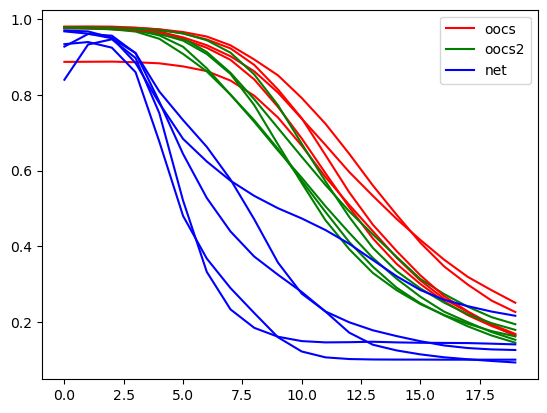

In [18]:
for i in range(5):
    plt.plot(OOCS_run_results[i]['sin acc'],color='r')
    plt.plot(OOCS2_run_results[i]['sin acc'],color='g')
    plt.plot(Net_run_results[i]['sin acc'],color='b')
    plt.legend(['oocs', 'oocs2', 'net'])

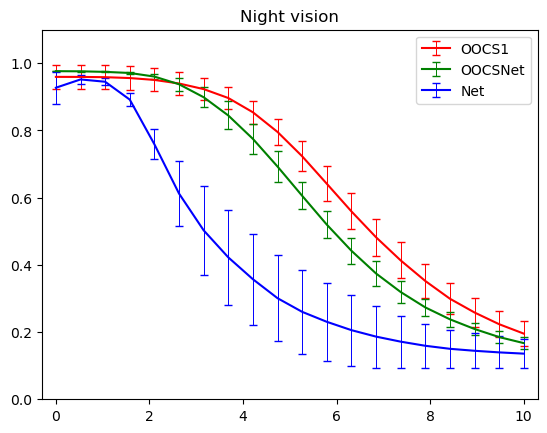

In [86]:
plt.errorbar(np.linspace(0,10,20),np.array([OOCS_run_results[i]['sin acc'] for i in range(5)]).T.mean(axis=1),
             np.array([OOCS_run_results[i]['sin acc'] for i in range(5)]).T.std(axis=1),color='r',capsize=3, elinewidth=0.7)
plt.errorbar(np.linspace(0,10,20),np.array([OOCS2_run_results[i]['sin acc'] for i in range(5)]).T.mean(axis=1),
             np.array([OOCS2_run_results[i]['sin acc'] for i in range(5)]).T.std(axis=1),color='g',capsize=3, elinewidth=0.7)
plt.errorbar(np.linspace(0,10,20),np.array([Net_run_results[i]['sin acc'] for i in range(5)]).T.mean(axis=1),
             np.array([Net_run_results[i]['sin acc'] for i in range(5)]).T.std(axis=1),color='b',capsize=3, elinewidth=0.7)

plt.legend(['oocs', 'oocs2', 'net'])
plt.ylim([0,1.1])
plt.xlim([-0.3,10.3])
plt.title('Night vision')
plt.legend(['OOCS1','OOCSNet','Net'])

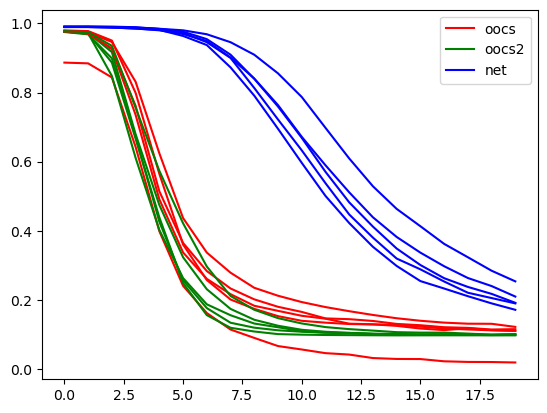

In [19]:
for i in range(5):
    plt.plot(OOCS_run_results[i]['gauss acc'],color='r')
    plt.plot(OOCS2_run_results[i]['gauss acc'],color='g')
    plt.plot(Net_run_results[i]['gauss acc'],color='b')
    plt.legend(['oocs', 'oocs2', 'net'])

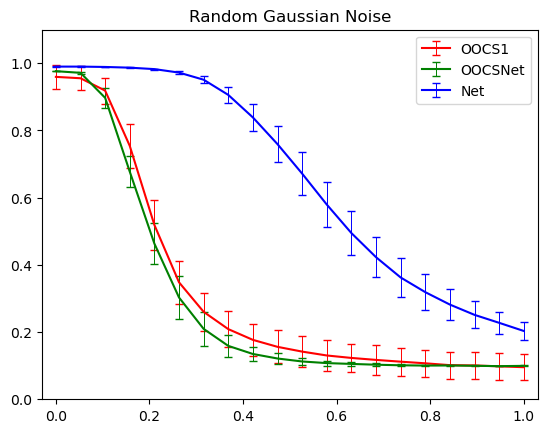

In [80]:
plt.errorbar(np.linspace(0,1,20),np.array([OOCS_run_results[i]['gauss acc'] for i in range(5)]).T.mean(axis=1),
             np.array([OOCS_run_results[i]['gauss acc'] for i in range(5)]).T.std(axis=1),color='r',capsize=3, elinewidth=0.7)
plt.errorbar(np.linspace(0,1,20),np.array([OOCS2_run_results[i]['gauss acc'] for i in range(5)]).T.mean(axis=1),
             np.array([OOCS2_run_results[i]['gauss acc'] for i in range(5)]).T.std(axis=1),color='g',capsize=3, elinewidth=0.7)
plt.errorbar(np.linspace(0,1,20),np.array([Net_run_results[i]['gauss acc'] for i in range(5)]).T.mean(axis=1),
             np.array([Net_run_results[i]['gauss acc'] for i in range(5)]).T.std(axis=1),color='b',capsize=3, elinewidth=0.7)

plt.ylim([0,1.1])
plt.xlim([-0.03,1.03])
plt.title('Random Gaussian Noise')
plt.legend(['OOCS1','OOCSNet','Net'])

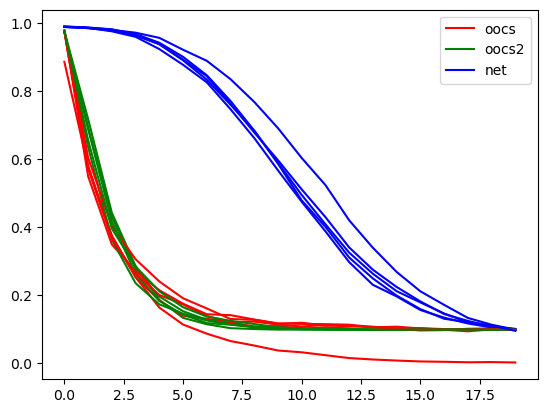

In [20]:
for i in range(5):
    plt.plot(OOCS_run_results[i]['noise acc'],color='r')
    plt.plot(OOCS2_run_results[i]['noise acc'],color='g')
    plt.plot(Net_run_results[i]['noise acc'],color='b')
    plt.legend(['oocs', 'oocs2', 'net'])

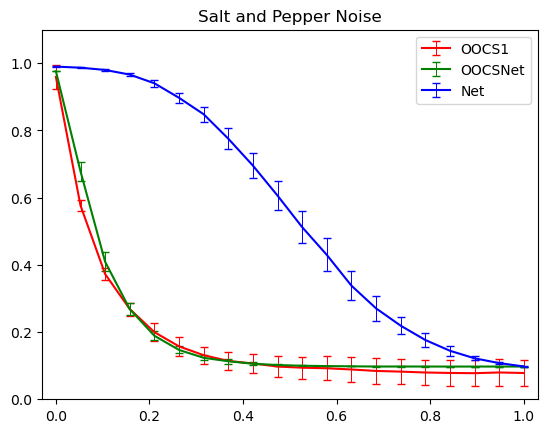

In [81]:
plt.errorbar(np.linspace(0,1,20),np.array([OOCS_run_results[i]['noise acc'] for i in range(5)]).T.mean(axis=1),
             np.array([OOCS_run_results[i]['noise acc'] for i in range(5)]).T.std(axis=1),color='r',capsize=3, elinewidth=0.7)
plt.errorbar(np.linspace(0,1,20),np.array([OOCS2_run_results[i]['noise acc'] for i in range(5)]).T.mean(axis=1),
             np.array([OOCS2_run_results[i]['noise acc'] for i in range(5)]).T.std(axis=1),color='g',capsize=3, elinewidth=0.7)
plt.errorbar(np.linspace(0,1,20),np.array([Net_run_results[i]['noise acc'] for i in range(5)]).T.mean(axis=1),
             np.array([Net_run_results[i]['noise acc'] for i in range(5)]).T.std(axis=1),color='b',capsize=3, elinewidth=0.7)

plt.ylim([0,1.1])
plt.xlim([-0.03,1.03])
plt.title('Salt and Pepper Noise')
plt.legend(['OOCS1','OOCSNet','Net'])

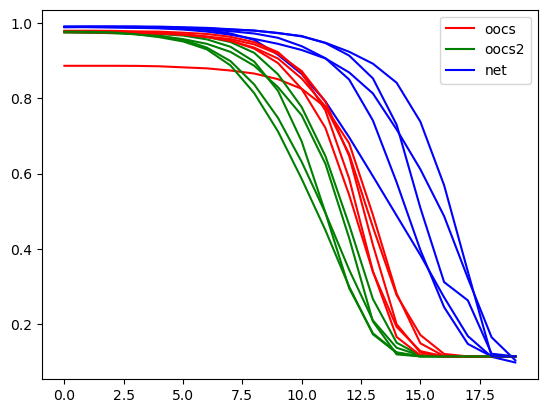

In [21]:
for i in range(5):
    plt.plot(OOCS_run_results[i]['con acc'],color='r')
    plt.plot(OOCS2_run_results[i]['con acc'],color='g')
    plt.plot(Net_run_results[i]['con acc'],color='b')
    plt.legend(['oocs', 'oocs2', 'net'])

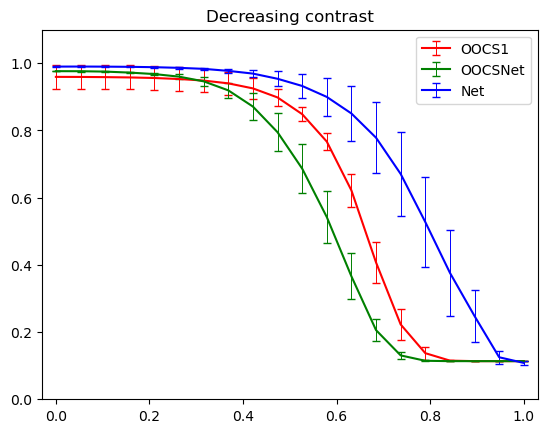

In [84]:
plt.errorbar(np.linspace(0,1,20),np.array([OOCS_run_results[i]['con acc'] for i in range(5)]).T.mean(axis=1),
             np.array([OOCS_run_results[i]['con acc'] for i in range(5)]).T.std(axis=1),color='r',capsize=3, elinewidth=0.7)
plt.errorbar(np.linspace(0,1,20),np.array([OOCS2_run_results[i]['con acc'] for i in range(5)]).T.mean(axis=1),
             np.array([OOCS2_run_results[i]['con acc'] for i in range(5)]).T.std(axis=1),color='g',capsize=3, elinewidth=0.7)
plt.errorbar(np.linspace(0,1,20),np.array([Net_run_results[i]['con acc'] for i in range(5)]).T.mean(axis=1),
             np.array([Net_run_results[i]['con acc'] for i in range(5)]).T.std(axis=1),color='b',capsize=3, elinewidth=0.7)

plt.ylim([0,1.1])
plt.xlim([-0.03,1.03])
plt.title('Decreasing contrast')
plt.legend(['OOCS1','OOCSNet','Net'])


In [67]:
print(np.array([OOCS_run_results[i]['original acc'] for i in range(5)]).T.mean())
print(np.array([OOCS_run_results[i]['original acc'] for i in range(5)]).T.std())
print(np.array([OOCS2_run_results[i]['original acc'] for i in range(5)]).T.mean())
print(np.array([OOCS2_run_results[i]['original acc'] for i in range(5)]).T.std())
print(np.array([Net_run_results[i]['original acc'] for i in range(5)]).T.mean())
print(np.array([Net_run_results[i]['original acc'] for i in range(5)]).T.std())

0.95952004
0.036483496
0.97652006
0.00077563117
0.9901
0.00060990977


In [68]:
print(np.array([OOCS_run_results[i]['inverted acc'] for i in range(5)]).T.mean())
print(np.array([OOCS_run_results[i]['inverted acc'] for i in range(5)]).T.std())
print(np.array([OOCS2_run_results[i]['inverted acc'] for i in range(5)]).T.mean())
print(np.array([OOCS2_run_results[i]['inverted acc'] for i in range(5)]).T.std())
print(np.array([Net_run_results[i]['inverted acc'] for i in range(5)]).T.mean())
print(np.array([Net_run_results[i]['inverted acc'] for i in range(5)]).T.std())

0.95952004
0.036483496
0.97652006
0.00077563117
0.102060005
0.0060872324


In [11]:
x_test_dark = []
for x in x_test:
    x_test_dark.append(abs(x - 1.0))
x_test_dark = np.array(x_test_dark)

x_test_noise = []
for x in x_test:
    x_test_noise.append(add_condiment(x, 0.1))
x_test_noise = np.array(x_test_noise)

x_test_gauss = []
for x in x_test:
    x_test_gauss.append(np.abs(x + np.random.normal(0, 0.1, (28,28))))
x_test_gauss = np.array(x_test_gauss)

x_test_con = []
for x in x_test:
    x_test_con.append(x + (1-x)*0.5)
x_test_con = np.array(x_test_con)

sin_acc,sin_loss = [],[]    
for amount in np.linspace(0,5,20):
    sin_arr = np.empty([28,28])
    sinn = np.sin(np.linspace(0,np.pi,28)) * 5
    for i in range(28):
        for j in range(28):
            sin_arr[i][j] = sinn[int(np.sqrt((14-i)**2+(14-j)**2))]

x_test_sin = []
for x in x_test:
    x_test_sin.append(np.clip(-np.inf, 1, x + 1- sin_arr))
x_test_sin = np.array(x_test_sin)



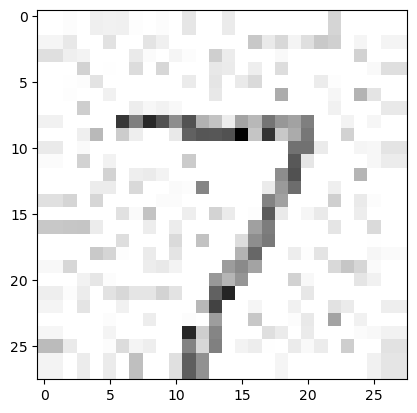

In [13]:
testset = x_test_gauss

filter_weights = tf.Variable(tf.cast(tf.reshape(On_Off_Center_filters(radius=1.0, gamma=1. / 2., in_channels=1, out_channels=1, off=False), (3, 3, 1, 1)),dtype=tf.float32), trainable=False, dtype=tf.float32)
on_output = tf.nn.relu(tf.nn.conv2d(tf.cast(tf.reshape(testset, [-1, 28, 28, 1]),tf.float32), filters=filter_weights, strides=1, padding='VALID'))
on_output = tf.pad(on_output, tf.constant([[0, 0], [1, 1], [1, 1],[0,0]]), "SYMMETRIC")
plt.imshow(on_output[0],cmap='binary')





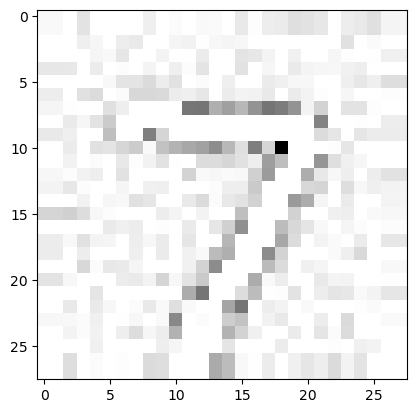

In [14]:
filter_weights = tf.Variable(tf.cast(tf.reshape(On_Off_Center_filters(radius=1.0, gamma=1. / 2., in_channels=1, out_channels=1, off=True), (3, 3, 1, 1)),dtype=tf.float32), trainable=False, dtype=tf.float32)
off_output = tf.nn.relu(tf.nn.conv2d(tf.cast(tf.reshape(testset, [-1, 28, 28, 1]),tf.float32), filters=filter_weights, strides=1, padding='VALID'))
off_output = tf.pad(off_output, tf.constant([[0, 0], [1, 1], [1, 1],[0,0]]), "SYMMETRIC")
plt.imshow(off_output[0],cmap='binary')

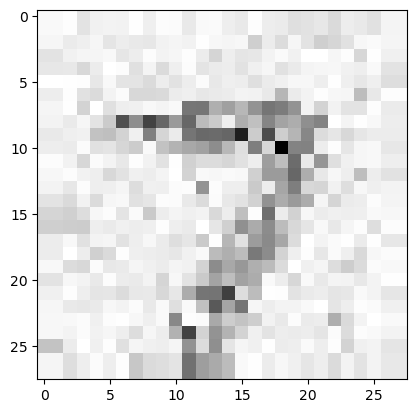

In [15]:
twin = off_output[0] + on_output[0]
plt.imshow(twin,cmap='binary')